Based on *Using a deep temporal convolutional network as a building energy surrogate model that spans multiple climate zones*
Recreation of Westermann et al., 2020

https://doi.org/10.1016/j.apenergy.2020.115563

https://gitlab.com/energyincities/building_surrogate_modelling

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
import os

# torch.cuda.empty_cache()

### CUDA checks

In [ ]:
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')
# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')
# print(torch.cuda.memory_summary())

In [ ]:
# is_cuda_runtime =  torch.cuda.is_available()
# if not is_cuda_runtime:
#   print("Change your runtime to a GPU-accelerated one.")
# else:
#   print("All good!")
# device = "cuda" if is_cuda_runtime else "cpu"\
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.memory_allocated()

# Imports

In [12]:
from storage import upload_to_bucket, download_from_bucket
from schedules import mutate_timeseries
from simulate import BatchSimulator
from schema import Schema

schema = Schema()

In [ ]:
# !pip install vapeplot &> /dev/null

In [24]:
# @markdown ### 0.4 | Styling
# import google
# import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
# is_dark = google.colab.output.eval_js(
#     'document.documentElement.matches("[theme=dark]")'
# )

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma");

<Figure size 640x480 with 0 Axes>

# Download & preprocess the data

## Weather file & schedules preprocessing

In [ ]:
# download_from_bucket(blob_name=f"climate_array.npy", file_name="./data/epws/climate_array.npy")
# download_from_bucket(blob_name=f"tsol.npy", file_name="./data/epws/tsol.npy")
# download_from_bucket(blob_name=f"default_schedules.npy", file_name="./data/template_libs/default_schedules.npy")

In [14]:
climate_array = np.load("./data/epws/climate_array.npy")
tsol_array = np.load("./data/epws/tsol.npy")
tsol_array = np.load("./data/epws/tsol.npy")
schedules = np.load("./data/template_libs/default_schedules.npy") # 3x8760

In [6]:
climate_array.shape

(392, 7, 8760)

Make a file in data called "hdf5"

## Normalization

First, let's set up the timeseries data

In [7]:
# TODO: normalize with the batch std? or recorded
# nornalization method?
# def normalize(data, mean, std):
    # return (data-mean)/std
def normalize(data, maxv, minv):
    return (data-minv)/(maxv-minv)

In [8]:
dbt_max = 50.0 # 50.5
dbt_min = -35.0
rh_max = 100.0
rh_min = 0.0 # 2.0
atm_max = 105800.0
atm_min = 75600.0
rad_min = 0.0
ghrad_max = 1200.0 #1154.0
dnrad_max = 1097.0
dhrad_max = 689.0
skyt_max = 32.3
skyt_min = -58.3
tsol_max = 60
tsol_min = -40

In [9]:
# Normalize the whole climate and tsol array
maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

norm_climate_array = np.zeros(climate_array.shape)
norm_tsol_array = np.zeros(tsol_array.shape)
for j in range(climate_array.shape[0]):
    for i in range(7):
        climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
    for i in range(4):
        norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

Schedules

Now for the building vector

In [18]:
building_vect_schema = [
    'width', 
    'height', 
    'facade_2_footprint', 
    'perim_2_footprint',
    'roof_2_footprint',
    'footprint_2_ground',
    'wwr',
    'orientation',
    'HeatingSetpoint',
    'CoolingSetpoint',
    'LightingPowerDensity',
    'EquipmentPowerDensity',
    'PeopleDensity',
    'Infiltration',
    'FacadeMass',
    'RoofMass',
    'FacadeRValue',
    'RoofRValue',
    'SlabRValue',
    ]
# Area
# wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

# building_vector = np.zeros((data_size, 22))
# for i, schema_name in enumerate(building_vect_schema):
#     column = schema[schema_name].extract_storage_values_batch(batch).flatten()
#     try:
#         column = normalize(column, schema[schema_name].max, schema[schema_name].min)
#     except:
#         print(f"Calculating mean from batch data for {schema_name}...")
#         column = normalize(column, np.max(column), np.min(column))
#     building_vector[:, i] = column
# building_vector[:, -3] = normalize(area, a_max, a_min)
# building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
# building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

In [ ]:
# for c in range(22):
#     y = building_vector[:, c]
#     # Add some random "jitter" to the x-axis
#     x = np.random.normal(c, 0.01, size=len(y))
#     plt.plot(x, y, '.', alpha=0.1)
# plt.boxplot(building_vector)
# plt.xticks(ticks = list(range(22)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
# plt.show()

And finally, the output energy data 

In [ ]:
#TODO separate min and max for heating and cooling?
# energy_min = 0
# energy_max = 7 * 10**9

# # Add core and perimeter together
# heating = monthly[:, 0, :]+monthly[:, 2, :]
# cooling = monthly[:, 1, :]+monthly[:, 3, :]
# results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

# norm_results = normalize(results, energy_max, energy_min)
# print(monthly.shape)
# ix = 17
# plt.figure()
# plt.plot(monthly[ix][0])
# plt.plot(monthly[ix][1])
# plt.plot(monthly[ix][2])
# plt.plot(monthly[ix][3])

In [ ]:
# for i in range(1000):
#     plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
#     plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
# plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
# plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
# plt.legend()
# plt.show()

# Sample Loader from Dataset

In [19]:
# the loading & preprocessing grouped into a function
def load_training_samples(schema,
    start_idx = 0,
    count = 20000,
    dbt_max = 50.0, # 50.5
    dbt_min = -35.0,
    rh_max = 100.0,
    rh_min = 0.0, # 2.0
    atm_max = 105800.0,
    atm_min = 75600.0,
    rad_min = 0.0,
    ghrad_max = 1200.0, #1154.0
    dnrad_max = 1097.0,
    dhrad_max = 689.0,
    skyt_max = 32.3,
    skyt_min = -58.3,
    tsol_max = 60,
    tsol_min = -40,
    a_max = 2000,
    a_min = 0,
    energy_min = 0,
    energy_max = 30, # 30 kWh/m2/mo
):
    with h5py.File(f"./data/model_data_manager/all_data_monthly.hdf5", 'r') as f:
        batch_size=count
        monthly = f["monthly"][start_idx:start_idx+batch_size] # this loads the whole batch into memory!
        # total_heating = f["total_heating"][0:batch_size] # this loads the whole batch into memory!
        # total_cooling = f["total_cooling"][0:batch_size] # this loads the whole batch into memory!
        # errors = f["errors"][...]
        area = f["area"][start_idx:start_idx+batch_size]
        batch = f["storage_batch"][start_idx:start_idx+batch_size]
    # Normalize the whole climate and tsol array
    maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
    mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

    norm_climate_array = np.zeros(climate_array.shape)
    norm_tsol_array = np.zeros(tsol_array.shape)
    for j in range(climate_array.shape[0]):
        for i in range(7):
            climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
        for i in range(4):
            norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

    # Schedules
    seeds = schema["schedules_seed"].extract_storage_values_batch(batch).astype(int) # 1x1
    operations_maps = schema["schedules"].extract_storage_values_batch(batch) # 3

    # timeseries_vector = np.zeros((data_size, 8, 8760))
    data_size = batch.shape[0]
    timeseries_vector = np.zeros((data_size, 11, 8760))
    orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
    idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
    # Get the weather file for each entry
    for i, epw_idx in enumerate(idxs):
        epw_idx = int(epw_idx)
        timeseries_vector[i, :-4, :] = norm_climate_array[epw_idx]
        timeseries_vector[i, -4:-1, :] = mutate_timeseries(schedules, operations_maps[i], seeds[i])
        timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

    

    building_vector = np.zeros((data_size, 22))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    building_vector[:, -3] = normalize(area, a_max, a_min)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

    # Add core and perimeter together
    heating = (monthly[:, 0, :]+monthly[:, 2, :]) / area.reshape(-1,1)
    cooling = (monthly[:, 1, :]+monthly[:, 3, :]) / area.reshape(-1,1)
    area_normed_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

    norm_results = normalize(area_normed_results, energy_max*2.777e7, energy_min*2.777e7)
    # TODO: MAKE THIS EUI?

    return building_vector, timeseries_vector, norm_results

# Load Part of the Dataset into Memory

Calculating mean from batch data for orientation...


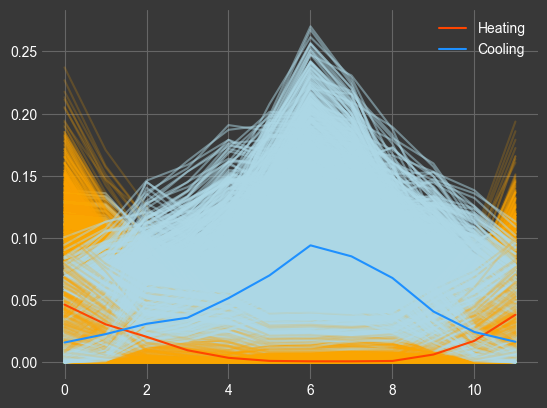

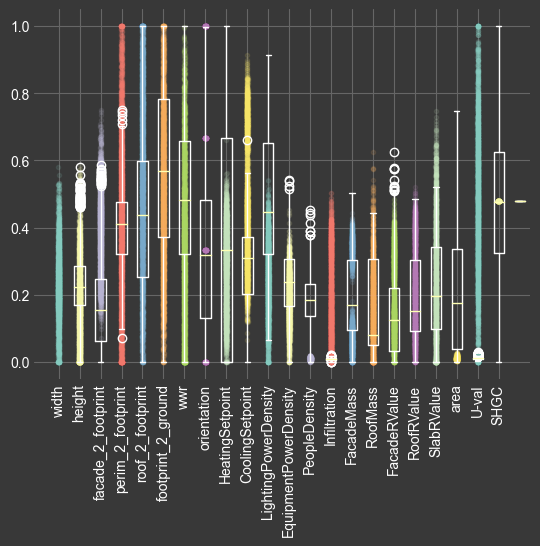

CPU times: total: 8.19 s
Wall time: 9.82 s


In [36]:
%%time
start_idx = 0
bldg_count = 3000

building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=bldg_count)

for i in range(bldg_count):
    plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
    plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
plt.legend()
plt.show()

for c in range(len(building_vect_schema) + 3):
    y = building_vector[:, c]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(c, 0.01, size=len(y))
    plt.plot(x, y, '.', alpha=0.1)
plt.boxplot(building_vector)
plt.xticks(ticks = list(range(22)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
plt.show()

# Set up the model

## Timeseries CNN

In [37]:
import torch.nn as nn
import torch.optim as optim

class EnergyTimeseriesCNNBlockA(nn.Module):
    def __init__(self, 
                 in_channels=11,
                 n_feature_maps = 64,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm1d(n_feature_maps), 
        )

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)

class EnergyTimeseriesCNNBlockB(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 n_feature_maps = 128,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.BatchNorm1d(n_feature_maps)

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)


class AnnualEnergyCNN(nn.Module):
    def __init__(self, 
               out_channels=22,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR ANNUAL
        self.GlobalAveragePool = nn.AvgPool1d(kernel_size=8760) # 1D? average across all feature maps
        self.linear = nn.Linear(in_features=n_feature_maps*2, out_features=out_channels)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.GlobalAveragePool(x)
        x = x.squeeze(-1)
        x = self.linear(x)
        return nn.functional.relu(x)

class MonthlyEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR MONTHLY (out is 2x12)
        self.month_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps*2,
                out_channels=out_channels,
                kernel_size=30,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
        )   
        self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.pooling(x)
        x = self.month_convolutional_layer(x)
        return nn.functional.relu(x)

## Energy surrogate

In [38]:
class EnergyCNN(torch.nn.Module):
    def __init__(self, 
                 in_channels=30,
                 n_feature_maps=64,
                 out_channels=2
                 ):
        super(EnergyCNN, self).__init__()

        # FOR MONTHLY (out is 2x12)
        self.in_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
            )
        
        self.out_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=out_channels,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
            )  
        # self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, sample):
        # sample (22+n, 1)
        x = self.in_convolutional_layer(sample)
        x = nn.functional.leaky_relu(x)
        x = self.out_convolutional_layer(x)
        x = nn.functional.leaky_relu(x)

        return x

## Init Models

In [39]:
latent_size = 22
building_vector_size = building_vector.shape[1]
energy_input_size = latent_size + building_vector_size
timeseries_model = MonthlyEnergyCNN(out_channels=latent_size).to(device)
energy_model = EnergyCNN(in_channels=energy_input_size).to(device)

# Dataloaders

First, split the data into training, validation, and testing (80/10/10).

In [41]:
def make_dataset(start_idx, count, loader_batch_size=100):
    torch.cuda.empty_cache()
    building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=count)
    dataset  = {}
    for i in range(building_vector.shape[0]):
        # DICT ENTRIES MUST BE IN ORDER
        dataset[i] = dict({
            "building_vector": np.array([building_vector[i]]*12).T,
            "timeseries_vector": timeseries_vector[i],
            "results_vector": norm_results[i],
        })
    generator = torch.Generator()
    generator.manual_seed(0)

    train, val, test = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=generator)
    training_dataloader = torch.utils.data.DataLoader(train, batch_size=loader_batch_size, shuffle=False)
    validation_dataloader = torch.utils.data.DataLoader(val, batch_size=loader_batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=loader_batch_size, shuffle=False)
    return {"datasets": {"train": train, "test": test, "validate": val}, "dataloaders": {"train": training_dataloader, "test": test_dataloader, "validate": validation_dataloader}}



# Train the model

In [50]:
timeseries_model.train()
energy_model.train()

n_epochs = 10
learning_rate = 1e-3
step_loss_frequency = 50
training_loss_history = []
validation_loss_history  = []
latentvect_history  = []

# LOSS FUNCTION
loss_function = nn.MSELoss()

# optimizer = torch.optim.Adam(energy_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(timeseries_model.parameters()) + list(energy_model.parameters()), lr=learning_rate)

print("making dataset...")
data = make_dataset(start_idx=0, count=20000, loader_batch_size=1000)
print("starting training...")
training_dataloader = data["dataloaders"]["train"]
validation_dataloader = data["dataloaders"]["validate"]

for epoch_num in range(n_epochs):
    print(f"------------------epoch number {epoch_num}------------------")
    for j, sample in enumerate(training_dataloader):
        optimizer.zero_grad()
        
        timeseries = sample["timeseries_vector"].to(device).float()
        bldg_vect = sample["building_vector"].to(device).float()
        # Repeat bldg_vect for monthly size:
        loads = sample["results_vector"].to(device).float()

        timeseries_latvect = timeseries_model(timeseries)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1).squeeze(1)
        # print(x.shape)

        predicted_loads = energy_model(x)

        loss = loss_function(loads, predicted_loads)

        if j%step_loss_frequency == 0:
            print(f"Step {j} loss: {loss.item()}")
            latentvect_history.append(timeseries_latvect.detach())
        
        training_loss_history.append([len(training_loss_history),loss.item()])

        loss.backward()
        optimizer.step()

    with torch.no_grad():
        epoch_validation_loss = []
        for sample in validation_dataloader:
            # SET UP SAMPLE DATA
            timeseries_val = sample["timeseries_vector"].to(device).float()
            # print(timeseries.shape)
            bldg_vect_val = sample["building_vector"].to(device).float()
            # Repeat bldg_vect for monthly size:
            # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
            loads = sample["results_vector"].to(device).float()

            timeseries_latvect_val = timeseries_model(timeseries_val)

            # Concatenate vectors
            x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

            predicted_loads = energy_model(x_val)

            loss = loss_function(loads, predicted_loads)
            
            epoch_validation_loss.append(loss.item())

        mean_validation_loss = np.mean(epoch_validation_loss)
        print(f"Mean validation loss for batch: {mean_validation_loss}")

        validation_loss_history.append([len(training_loss_history), mean_validation_loss])

making dataset...
Calculating mean from batch data for orientation...
starting training...
------------------epoch number 0------------------
Step 0 loss: 0.0014429646544158459
Step 50 loss: 0.0006335510988719761
Step 100 loss: 0.0005795118631795049
Step 150 loss: 0.0005148050258867443
Mean validation loss for batch: 0.0006194087938638404
------------------epoch number 1------------------
Step 0 loss: 0.0006952840485610068
Step 50 loss: 0.0004970614099875093
Step 100 loss: 0.0004917983314953744
Step 150 loss: 0.0004672365612350404
Mean validation loss for batch: 0.0005330404397682287
------------------epoch number 2------------------
Step 0 loss: 0.0007673842483200133
Step 50 loss: 0.00040127249667420983
Step 100 loss: 0.00045576374395750463
Step 150 loss: 0.00037267463630996644
Mean validation loss for batch: 0.0004682613740442321
------------------epoch number 3------------------
Step 0 loss: 0.0006455483962781727
Step 50 loss: 0.0003683206741698086
Step 100 loss: 0.00036503185401670

KeyboardInterrupt: 

In [ ]:
# Save checkpoint
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M")
uid = 'ZL'
torch.save({
    'epoch': epoch_num,
    'model_state_dict': timeseries_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    f"./checkpoints/{timestamp}_timeseries_{uid}.pt"
)
torch.save({
    'epoch': epoch_num,
    'model_state_dict': energy_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    f"./checkpoints/{timestamp}_energy_{uid}.pt"
)

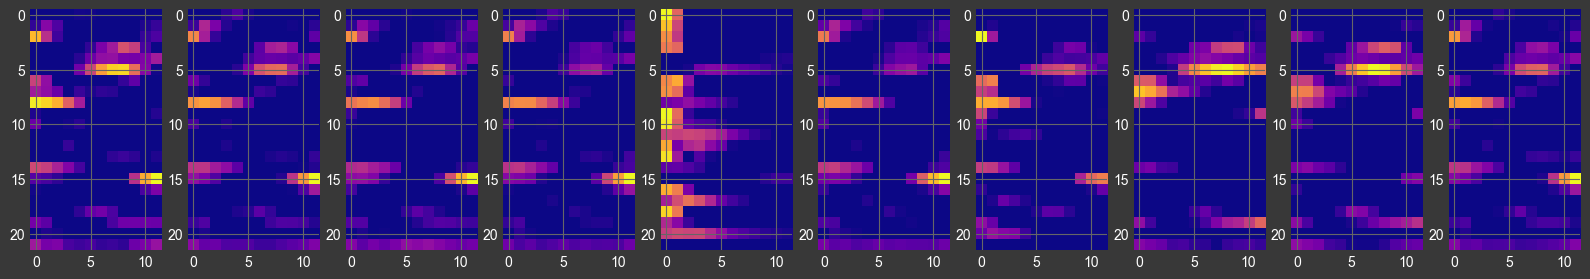

In [51]:
# do a visualization of data after each block?
bldgs_to_plot = 10
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20,10))
for i in range(bldgs_to_plot):
    ax[i].imshow(timeseries_latvect[int(np.random.rand()*timeseries_latvect.shape[0])].detach().cpu().numpy())
    # ax[i].set_axis("off")

Plot the training and validation loss and history

(1, 2)


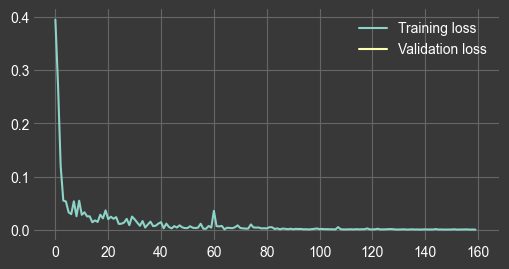

In [45]:
training_loss_history_array = np.array(training_loss_history)
validation_loss_history_array = np.array(validation_loss_history)

plt.figure(figsize=(6,3))
plt.plot(training_loss_history_array[:,0],training_loss_history_array[:,1], label="Training loss")
plt.plot(validation_loss_history_array[:,0],validation_loss_history_array[:,1], label="Validation loss")
plt.legend()
plt.show()

# Testing

In [46]:
timeseries_model.eval()
energy_model.eval()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(44, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [47]:
all_loads = []
all_results = []
unseen_climates = make_dataset(start_idx=150000, count=3000)
test_dataloader = unseen_climates["dataloaders"]["test"]
with torch.no_grad():
    for test_samples in test_dataloader:
        test_samples = next(iter(test_dataloader))
        timeseries = test_samples["timeseries_vector"].to(device).float()
        bldg_vect = test_samples["building_vector"].to(device).float()
        loads = test_samples["results_vector"].to(device).float()

        # print("bldg_vect: ", bldg_vect.shape)
        # print("timeseries: ", timeseries.shape)
        # print("loads: ", loads.shape)
        timeseries_latvect = timeseries_model(timeseries)
        # print("latent: ", timeseries_latvect.shape)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
        x = x.squeeze(1)
        # print("energy input: ", x.shape)

        predicted_loads = energy_model(x)
        all_loads.append(loads)
        all_results.append(predicted_loads)

        loss = loss_function(loads, predicted_loads)

all_loads = torch.vstack(all_loads)
all_results = torch.vstack(all_results)



Calculating mean from batch data for orientation...


In [ ]:
# i = 200
for i in range(10):
    plt.figure()
    plt.plot(all_loads[i, 0, :].cpu(), "-o",label="Predicted heating")
    plt.plot(all_loads[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), label="Actual cooling")
    plt.ylim([-0.01,0.5])
    plt.legend()
    plt.show()

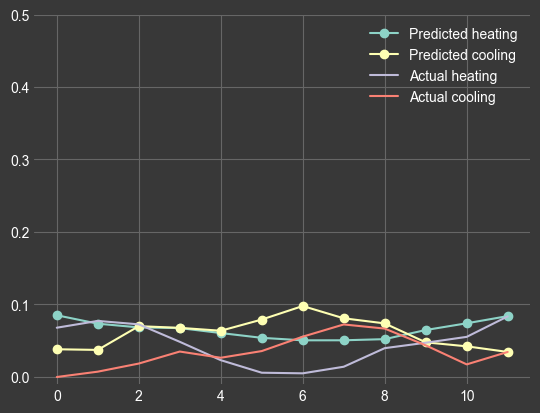

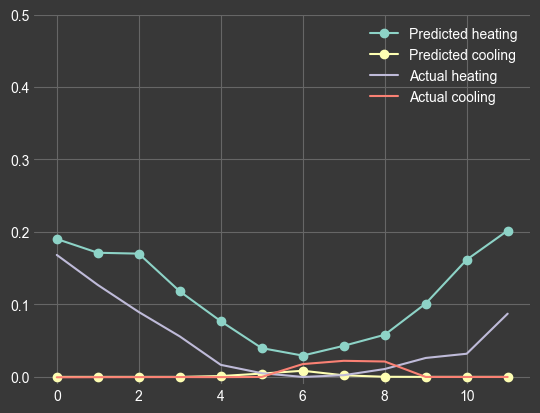

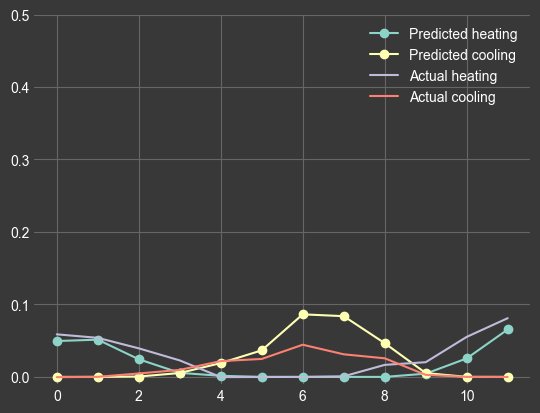

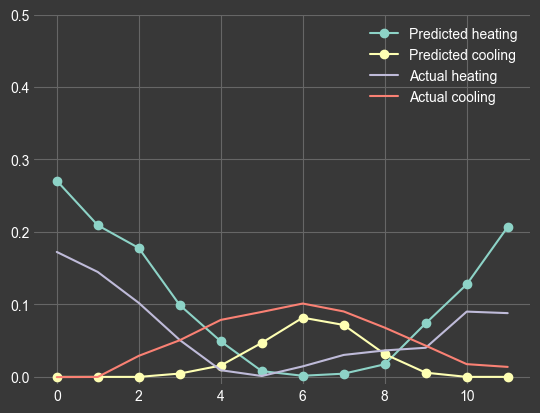

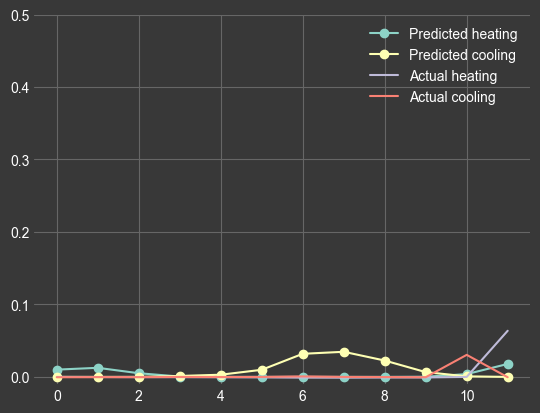

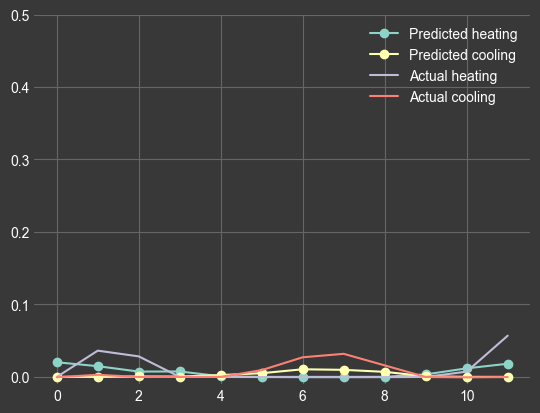

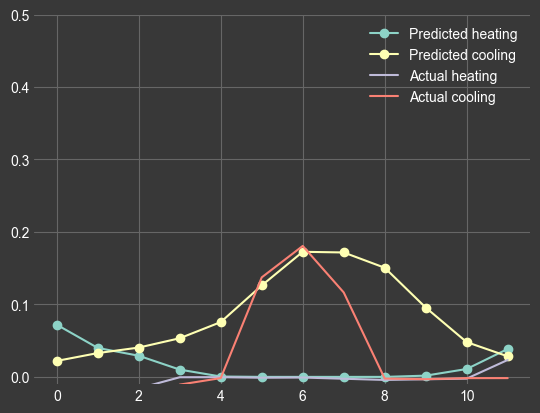

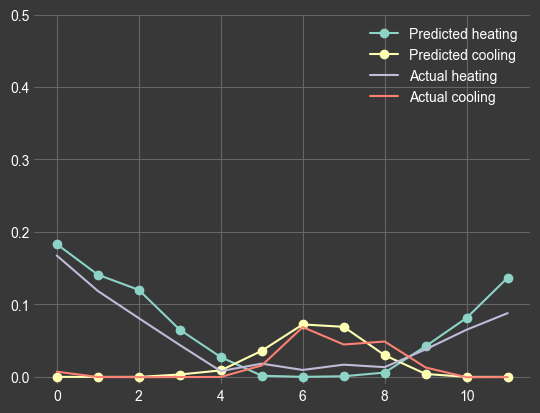

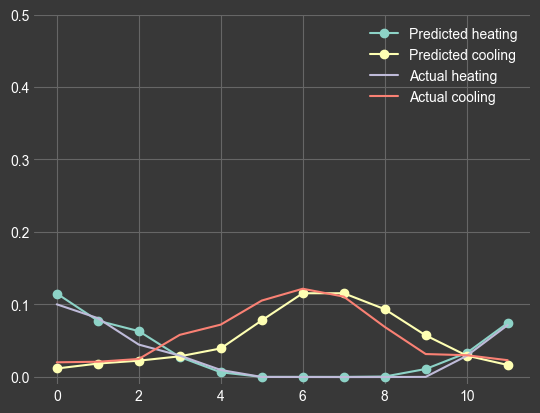

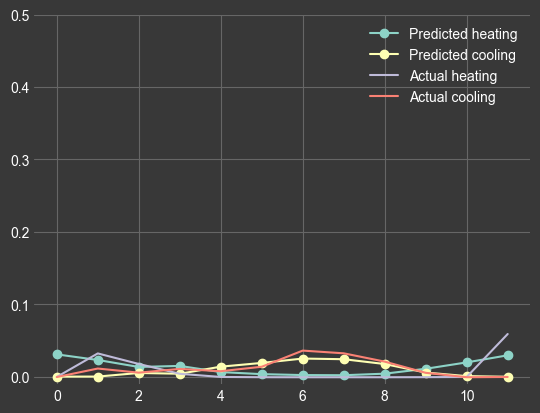

In [48]:
# i = 200
for i in range(10):
    plt.figure()
    plt.plot(all_loads[i, 0, :].cpu(), "-o",label="Predicted heating")
    plt.plot(all_loads[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), label="Actual cooling")
    plt.ylim([-0.01,0.5])
    plt.legend()
    plt.show()

# Visualizations
- Latent space - T-sne
- 